In [ ]:
# Importing required libraries

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
# Checking if a GPU is available for computations, otherwise default to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# Load the dataset

file_path = 'SeoulBikeData.csv'
data = pd.read_csv(file_path, encoding='latin1')

In [ ]:
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
# Preprocess the date column
# Convert the 'Date' column into a datetime object and extract year, month, and day as separate columns

data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data.drop(columns=['Date'], inplace=True)

In [ ]:
# Cyclical encoding for Hour and Month
# Apply cyclical encoding to 'Hour' and 'Month' for better representation in the model

data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)
data.drop(['Hour', 'Month'], axis=1, inplace=True)

In [ ]:
data.head()

,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Day,Hour_sin,Hour_cos,Month_sin,Month_cos
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,0.000000,1.000000,-2.449294e-16,1.0
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,0.258819,0.965926,-2.449294e-16,1.0
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,0.500000,0.866025,-2.449294e-16,1.0
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,0.707107,0.707107,-2.449294e-16,1.0
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,0.866025,0.500000,-2.449294e-16,1.0


In [ ]:
data.dtypes # Check data types of columns

Rented Bike Count              int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
Year                           int32
Day                            int32
Hour_sin                     float64
Hour_cos                     float64
Month_sin                    float64
Month_cos                    float64
dtype: object

# Encoding Object Datatypes using One-Hot Encoding

In [ ]:
# One-hot encoding for Seasons

data = pd.get_dummies(data, columns=['Seasons'], drop_first=False)

In [ ]:
# One-hot encoding for Holiday and Functioning Day

data = pd.get_dummies(data, columns=['Holiday', 'Functioning Day'], drop_first=False)

In [ ]:
data.dtypes # Check data types of columns

Rented Bike Count              int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Year                           int32
Day                            int32
Hour_sin                     float64
Hour_cos                     float64
Month_sin                    float64
Month_cos                    float64
Seasons_Autumn                  bool
Seasons_Spring                  bool
Seasons_Summer                  bool
Seasons_Winter                  bool
Holiday_Holiday                 bool
Holiday_No Holiday              bool
Functioning Day_No              bool
Functioning Day_Yes             bool
dtype: object

In [ ]:
data.head()

,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Year,...,Month_sin,Month_cos,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,2017,...,-2.449294e-16,1.0,False,False,False,True,False,True,False,True
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,2017,...,-2.449294e-16,1.0,False,False,False,True,False,True,False,True
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,2017,...,-2.449294e-16,1.0,False,False,False,True,False,True,False,True
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,2017,...,-2.449294e-16,1.0,False,False,False,True,False,True,False,True
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,2017,...,-2.449294e-16,1.0,False,False,False,True,False,True,False,True


In [ ]:
# Generate a correlation matrix to identify relationships between features
 
correlation_matrix = data.corr()
correlation_matrix

,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Year,...,Month_sin,Month_cos,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
Rented Bike Count,1.000000,0.538558,-0.199780,0.121108,0.199280,0.379788,0.261837,-0.123074,-0.141804,2.151618e-01,...,-2.442890e-01,-3.994031e-01,1.027530e-01,2.288822e-02,2.965494e-01,-4.249251e-01,-7.233757e-02,7.233757e-02,-0.203943,0.203943
Temperature(°C),0.538558,1.000000,0.159371,-0.036252,0.034794,0.912798,0.353505,0.050282,-0.218405,3.777958e-01,...,-4.955616e-01,-7.569603e-01,5.972825e-02,7.959684e-03,6.658462e-01,-7.387196e-01,-5.593084e-02,5.593084e-02,0.050170,-0.050170
Humidity(%),-0.199780,0.159371,1.000000,-0.336683,-0.543090,0.536894,-0.461919,0.236397,0.108183,3.592468e-02,...,-1.703203e-01,-2.026380e-01,2.836650e-02,1.569416e-02,1.925949e-01,-2.382952e-01,-5.027765e-02,5.027765e-02,0.020800,-0.020800
Wind speed (m/s),0.121108,-0.036252,-0.336683,1.000000,0.171507,-0.176486,0.332274,-0.019674,-0.003554,-3.780878e-03,...,1.729095e-01,1.671976e-02,-1.280093e-01,8.385451e-02,-6.469790e-02,1.091865e-01,2.301677e-02,-2.301677e-02,-0.005037,0.005037
Visibility (10m),0.199280,0.034794,-0.543090,0.171507,1.000000,-0.176630,0.149738,-0.167629,-0.121695,5.238110e-02,...,-2.206436e-01,9.912367e-03,1.174133e-01,-1.874983e-01,6.195792e-02,8.616224e-03,3.177281e-02,-3.177281e-02,0.026000,-0.026000
Dew point temperature(°C),0.379788,0.912798,0.536894,-0.176486,-0.176630,1.000000,0.094381,0.125597,-0.150887,3.363497e-01,...,-5.004186e-01,-7.261556e-01,6.287829e-02,2.055888e-03,6.523778e-01,-7.223664e-01,-6.675910e-02,6.675910e-02,0.052837,-0.052837
Solar Radiation (MJ/m2),0.261837,0.353505,-0.461919,0.332274,0.149738,0.094381,1.000000,-0.074290,-0.072301,1.280860e-01,...,-2.205032e-02,-2.201085e-01,-3.137428e-02,7.997416e-02,1.284017e-01,-1.784202e-01,-5.077255e-03,5.077255e-03,0.007665,-0.007665
Rainfall(mm),-0.123074,0.050282,0.236397,-0.019674,-0.167629,0.125597,-0.074290,1.000000,0.008500,2.752192e-02,...,-2.440129e-02,-7.185402e-02,-1.324655e-02,1.759519e-02,5.392817e-02,-5.875456e-02,-1.426911e-02,1.426911e-02,-0.002055,0.002055
Snowfall (cm),-0.141804,-0.218405,0.108183,-0.003554,-0.121695,-0.150887,-0.072301,0.008500,1.000000,-2.064178e-01,...,3.572781e-02,2.150463e-01,-2.474218e-02,-9.978516e-02,-9.978516e-02,2.258745e-01,-1.259072e-02,1.259072e-02,-0.032089,0.032089
Year,0.215162,0.377796,0.035925,-0.003781,0.052381,0.336350,0.128086,0.027522,-0.206418,1.000000e+00,...,-2.323275e-03,-4.309865e-01,1.755711e-01,1.768562e-01,1.768562e-01,-5.325406e-01,-1.121635e-01,1.121635e-01,0.056873,-0.056873


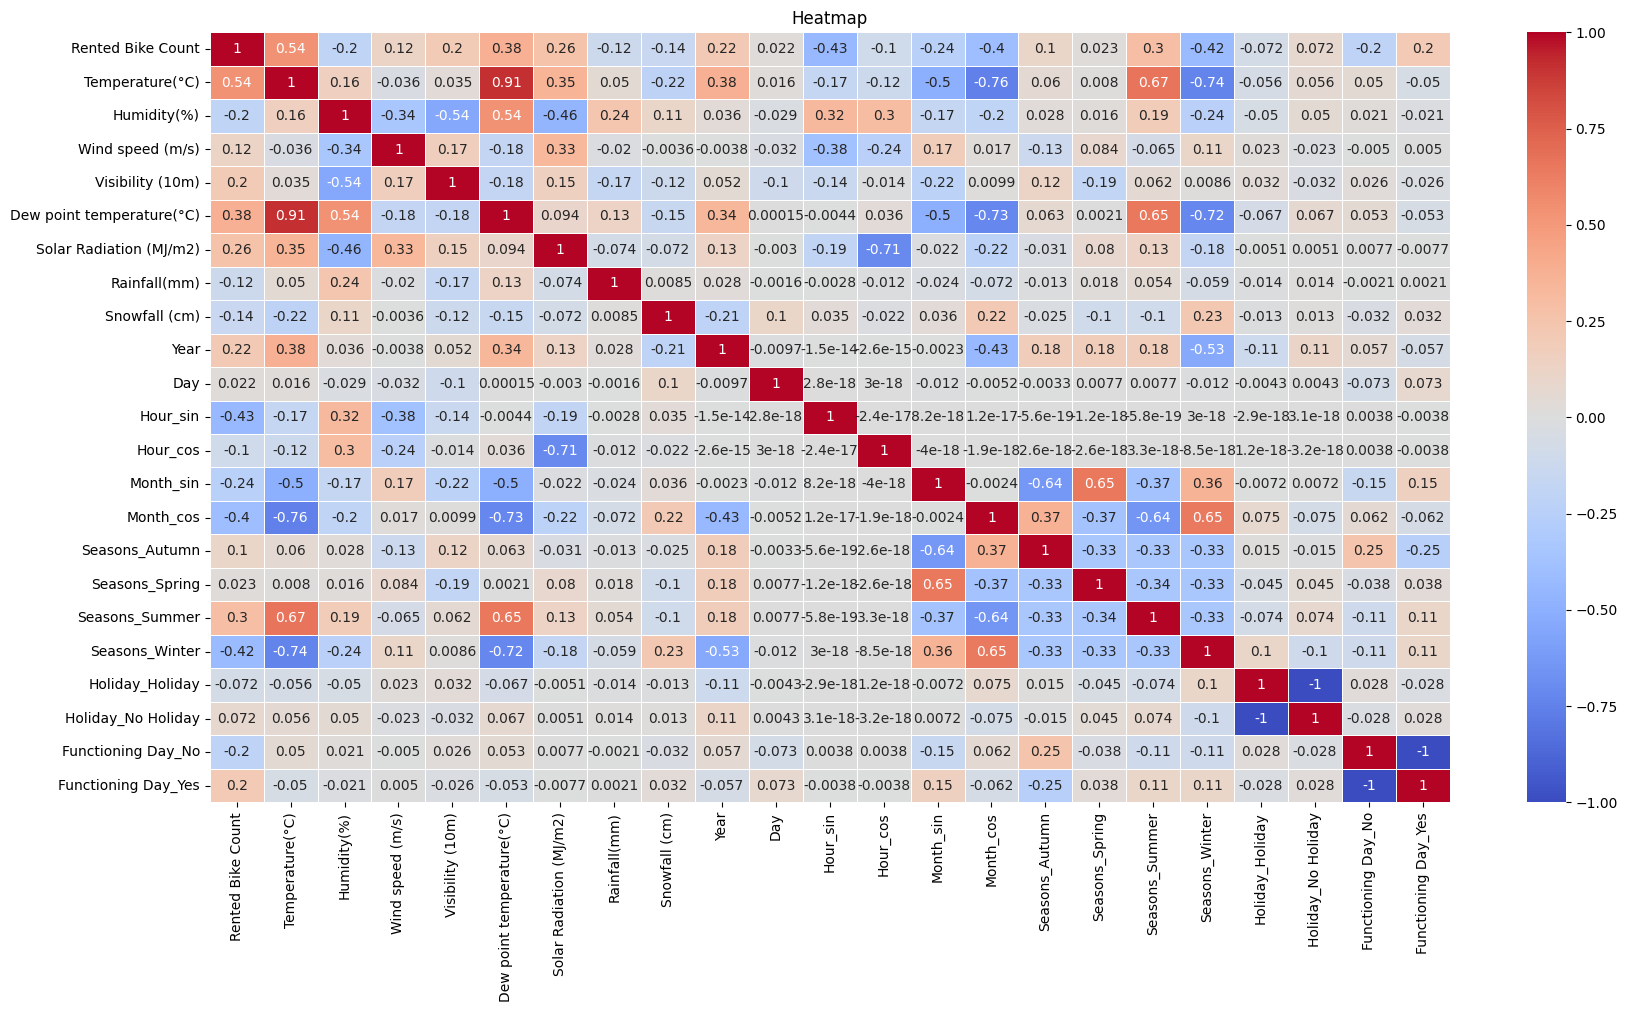

In [ ]:
# Visualize the correlation matrix using a heatmap

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5,vmax=1, vmin=-1)
plt.title("Heatmap")
plt.show()

In [ ]:
# Drop less relevant features based on the correlation analysis

columns_to_drop = ['Rainfall(mm)', 'Snowfall (cm)']
data.drop(columns=columns_to_drop, inplace=True)

In [ ]:
data.head()

,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Year,Day,Hour_sin,...,Month_sin,Month_cos,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,254,-5.2,37,2.2,2000,-17.6,0.0,2017,1,0.000000,...,-2.449294e-16,1.0,False,False,False,True,False,True,False,True
1,204,-5.5,38,0.8,2000,-17.6,0.0,2017,1,0.258819,...,-2.449294e-16,1.0,False,False,False,True,False,True,False,True
2,173,-6.0,39,1.0,2000,-17.7,0.0,2017,1,0.500000,...,-2.449294e-16,1.0,False,False,False,True,False,True,False,True
3,107,-6.2,40,0.9,2000,-17.6,0.0,2017,1,0.707107,...,-2.449294e-16,1.0,False,False,False,True,False,True,False,True
4,78,-6.0,36,2.3,2000,-18.6,0.0,2017,1,0.866025,...,-2.449294e-16,1.0,False,False,False,True,False,True,False,True


In [ ]:
# Split the data into features (X) and target (y), then into training and testing sets


X = data.drop('Rented Bike Count', axis=1)
y = data['Rented Bike Count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize the features for better performance during training

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Defining the Neural Network Model

class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.hidden1 = nn.Linear(input_size, 64)  # First hidden layer
        self.hidden2 = nn.Linear(64, 32)         # Second hidden layer
        self.output = nn.Linear(32, 1)          # Output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))  # Apply ReLU activation to the first hidden layer
        x = F.relu(self.hidden2(x))  # Apply ReLU activation to the second hidden layer
        return self.output(x)        # Return the final output

In [ ]:
# Convert the standardized data into PyTorch tensors and move to the selected device (CPU/GPU)

X_train_tensor = torch.tensor(X_train, dtype = torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32).to(device).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32).to(device).view(-1, 1)

In [ ]:
# Check the shapes of the training and testing tensors to ensure they align with model input and output requirements

X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([7008, 20]),
 torch.Size([7008, 1]),
 torch.Size([1752, 20]),
 torch.Size([1752, 1]))

In [ ]:
# Initialize the neural network model

input_size = X_train.shape[1]
model = LinearRegressionModel(input_size).to(device)

In [ ]:
model

LinearRegressionModel(
  (hidden1): Linear(in_features=20, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
# Define the loss function (Mean Squared Error) and optimizer (Adam)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Model and Evaluation

In [ ]:
# Train the model for a specified number of epochs

num_epochs = 3000
train_losses = []  # Store training losses
val_losses = []    # Store validation losses

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)  # Compute training loss

    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Backpropagate to compute gradients
    optimizer.step()       # Update model weights
    train_losses.append(loss.item())

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        val_loss = criterion(y_pred_tensor, y_test_tensor)  # Compute validation loss
        val_losses.append(val_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')


Epoch [100/3000], Training Loss: 875777.0000, Validation Loss: 874863.6875
Epoch [200/3000], Training Loss: 571013.2500, Validation Loss: 573463.3125
Epoch [300/3000], Training Loss: 248627.4688, Validation Loss: 261948.3281
Epoch [400/3000], Training Loss: 187862.2969, Validation Loss: 203629.8750
Epoch [500/3000], Training Loss: 171247.0469, Validation Loss: 188285.0469
Epoch [600/3000], Training Loss: 161494.7969, Validation Loss: 179547.2344
Epoch [700/3000], Training Loss: 154523.3750, Validation Loss: 173285.3281
Epoch [800/3000], Training Loss: 149266.2500, Validation Loss: 168509.2188
Epoch [900/3000], Training Loss: 144840.5625, Validation Loss: 164345.0156
Epoch [1000/3000], Training Loss: 140739.7188, Validation Loss: 160304.0781
Epoch [1100/3000], Training Loss: 136626.8281, Validation Loss: 156169.1719
Epoch [1200/3000], Training Loss: 132614.4531, Validation Loss: 152125.9844
Epoch [1300/3000], Training Loss: 128724.8438, Validation Loss: 148005.5625
Epoch [1400/3000], Tr

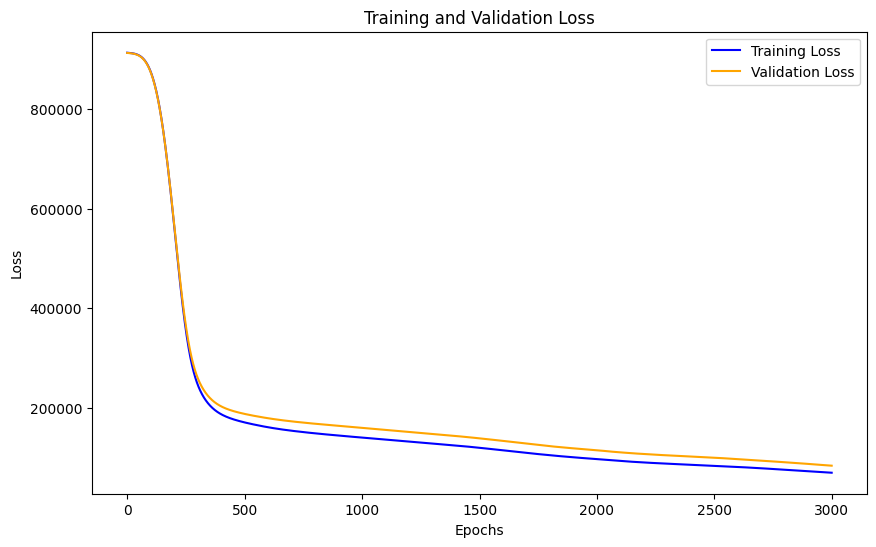

In [ ]:
# Plot training and validation loss to monitor overfitting

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(num_epochs), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model performance on test data

y_pred = y_pred_tensor.cpu().numpy()  # Convert predictions to NumPy array
y_test_np = y_test_tensor.cpu().numpy()  # Convert actual values to NumPy array

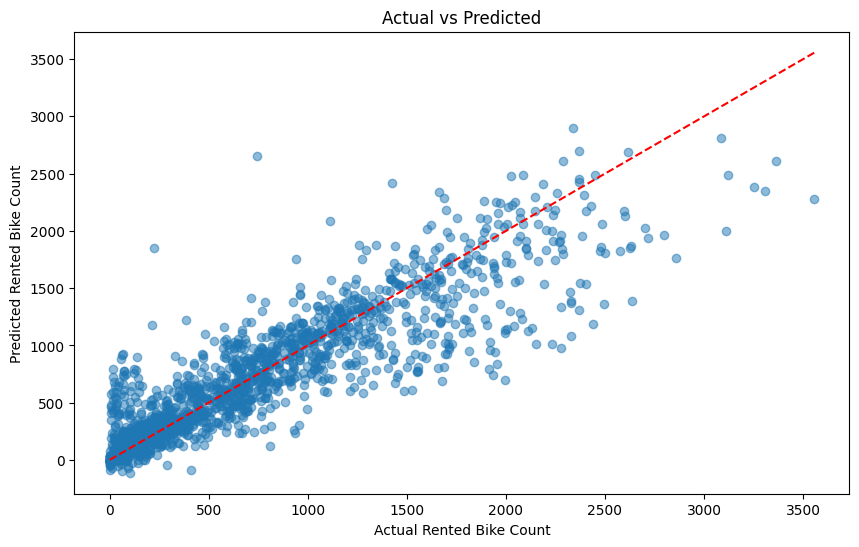

In [ ]:
# Visualize actual vs. predicted values using a scatter plot

plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred, alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Actual Rented Bike Count')
plt.ylabel('Predicted Rented Bike Count')
plt.title('Actual vs Predicted')
plt.show()

In [ ]:
# Compute evaluation metrics

mae = mean_absolute_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.4f}")

Mean Absolute Error: 185.46
R-squared: 0.7975


In [ ]:
# Predicting bike rentals for each season based on a input
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']

In [ ]:
season_predictions = []

for season in seasons:
    new_input = {col: 0 for col in X.columns}  # Initialize all inputs as zero
    new_input.update({
        'Temperature(°C)': 39,
        'Humidity(%)': 39,
        'Wind speed (m/s)': 5.5,
        'Visibility (10m)': 500,
        'Solar Radiation (MJ/m2)': 1,
        'Hour_sin': np.sin(2 * np.pi * 1 / 24),  # 2 PM
        'Hour_cos': np.cos(2 * np.pi * 1 / 24),
        'Month_sin': np.sin(2 * np.pi * 8 / 12),  #  August
        'Month_cos': np.cos(2 * np.pi * 8 / 12),
        f'Seasons_{season}': 1,  # On Season
        'Holiday_No Holiday': 0,  # Holiday
        'Functioning Day_Yes': 0,  # Non-functioning day
        'Year': 2024,
        'Day': 98
    })

    input_df = pd.DataFrame([new_input])[X.columns]  # Create a DataFrame from the input
    input_scaled = scaler.transform(input_df)  # Scale the input
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        prediction = model(input_tensor).cpu().numpy()[0][0]  # Make a prediction
    season_predictions.append((season, prediction))

# Display predictions
for season, pred in season_predictions:
    print(f"Predicted Rented Bike Count for {season}: {pred:.2f}")

Predicted Rented Bike Count for Spring: 2913.41
Predicted Rented Bike Count for Summer: 3032.60
Predicted Rented Bike Count for Autumn: 3084.73
Predicted Rented Bike Count for Winter: 2515.38


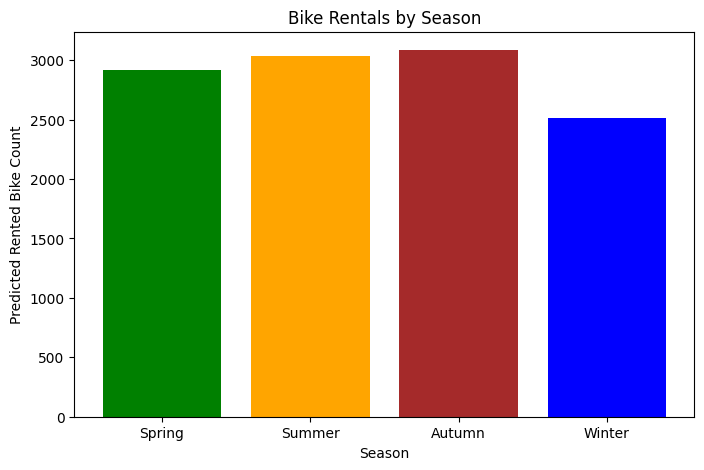

In [ ]:
# Visualization of seasonal predictions
seasons = [sp[0] for sp in season_predictions]
predictions = [sp[1] for sp in season_predictions]

plt.figure(figsize=(8, 5))
plt.bar(seasons, predictions, color=['green', 'orange', 'brown', 'blue'])
plt.xlabel('Season')
plt.ylabel('Predicted Rented Bike Count')
plt.title('Bike Rentals by Season')
plt.show()